In [1]:
import asyncio
import logging
import os
import time
import urllib
import warnings

import awkward as ak
import cabinetry
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import transforms, NanoEventsFactory
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from func_adl import ObjectStream
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.basicConfig(format="%(levelname)s - %(name)s - %(message)s")
logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
xsec_info = {
    "ttbar": 396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
    "single_top_s_chan": 2.0268 + 1.2676,
    "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
    "single_top_tW": 37.936 + 37.906,
    "wjets": 61457 * 0.252,  # e/mu+nu final states
    "data": None
}

In [3]:
class AGCSchema(BaseSchema):
    # credit to Mat Adamec for implementing this schema
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n,
        # as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (
                    k.startswith("n") | k.startswith("met") | k.startswith("GenPart") | k.startswith("PV")
        )]
        
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {
                k[len(name) + 1 :]: branch_forms[k]
                for k in branch_forms
                if (k.startswith(name + "_") & (k[len(name) + 1 :] != "e"))
            }
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [4]:
class AGCSchema_nanoAOD(BaseSchema):
    # credit to Mat Adamec for implementing this schema
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        
        names = set([k.split('_')[0] for k in branch_forms.keys()])
        names = [k for k in names if not (k.startswith("n") | 
                                          k.startswith("HTXS") | 
                                          k.startswith("HL") | 
                                          k.startswith("Puppi") | 
                                          k.startswith("Raw") | 
                                          k.startswith("LHE") | 
                                          k.startswith("Soft") |
                                          k.startswith("Gen") |
                                          k.startswith("gen") |
                                          k.startswith("fixed") | 
                                          k.startswith("C") |
                                          k.startswith("D") |
                                          k.startswith("F") |
                                          k.startswith("MET") |
                                          k.startswith("L1") |
                                          k.startswith("PSWeight") | 
                                          k.startswith("PV") | 
                                          k.startswith("Pileup") |
                                          k.startswith("Other") |
                                          k.startswith("TkMET") |
                                          k.startswith("btagWeight") |
                                          k.startswith("lum") |
                                          k.startswith("run") |
                                          k.startswith("event") |
                                          k.startswith("SV"))]
        
        
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['n' + name])
            content = {
                k[len(name) + 1 :]: branch_forms[k]
                for k in branch_forms
                if (k.startswith(name + "_") & (not k[len(name) + 1 :] in ["btagCSVV2"]))
            }
            
            if name == "Jet": content['btag'] = branch_forms[name+'_btagCSVV2']
            
            output[name] = zip_forms(content, name, 'PtEtaPhiMLorentzVector', offsets=offsets)

        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [5]:
def process_events(filename, storagename, schema, treepath):
    
    if not os.path.exists(storagename):
        urllib.request.urlretrieve(filename, filename=storagename)
        
    f = uproot.open(storagename)
    
    events = NanoEventsFactory.from_root(storagename, schemaclass=schema, treepath=treepath).events()
    
    return events

In [6]:
def get_top_mass(events):
    
    # pT > 25 GeV for leptons & jets    
    selected_electrons = events.Electron[events.Electron.pt > 25]
    selected_muons = events.Muon[events.Muon.pt > 25]
    selected_jets = events.Jet[events.Jet.pt > 25]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.8
    event_filters = event_filters & (ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2)

    # apply filters
    selected_jets = selected_jets[event_filters]

    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    reconstructed_top_mass = ak.flatten(trijet_mass) 
    
    return reconstructed_top_mass

In [28]:
def get_ht(events):
    
        # pT > 25 GeV for leptons & jets    
    selected_electrons = events.Electron[events.Electron.pt > 25]
    selected_muons = events.Muon[events.Muon.pt > 25]
    selected_jets = events.Jet[events.Jet.pt > 25]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.8
    event_filters = event_filters & (ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) == 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    ht = ak.sum(selected_jets.pt, axis=-1)
    
    return ht

In [29]:
def get_weights(events, process, xsec_info=xsec_info):
    if not process in xsec_info.keys():
        raise NameError(f"{process} not in {xsec_info.keys()}")
        
    x_sec = xsec_info[process]
    nevts_total = len(events)
    lumi = 3378 # /pb
    return x_sec * lumi / nevts_total

In [30]:
events_tt = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0005.root",
                           "ttbar.root",
                           AGCSchema_nanoAOD,
                           "Events")

events_sc = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8/cmsopendata2015_single_top_s_chan_19394_PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1_70000_0000.root",
                           "schannel.root",
                           AGCSchema_nanoAOD,
                           "Events")

events_tc = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/ST_t-channel_antitop_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1/cmsopendata2015_single_top_t_chan_19406_PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1_00000_0009.root",
                           "tchannel.root",
                           AGCSchema_nanoAOD,
                           "Events")

events_tw = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/ST_tW_antitop_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M1/cmsopendata2015_single_top_tW_19412_PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1_20000_0000.root",
                           "tw.root",
                           AGCSchema_nanoAOD,
                           "Events")

events_wj = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/cmsopendata2015_wjets_20548_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0025.root",
                           "wjet.root",
                           AGCSchema_nanoAOD,
                           "Events")

In [31]:
# get weights
weights_tt = get_weights(events_tt, "ttbar")
weights_sc = get_weights(events_sc, "single_top_s_chan")
weights_tc = get_weights(events_tc, "single_top_t_chan")
weights_tw = get_weights(events_tw, "single_top_tW")
weights_wj = get_weights(events_wj, "wjets")

In [32]:
topmass_tt = get_top_mass(events_tt)
topmass_sc = get_top_mass(events_sc)
topmass_tc = get_top_mass(events_tc)
topmass_tw = get_top_mass(events_tw)
topmass_wj = get_top_mass(events_wj)

In [33]:
ht_tt = get_ht(events_tt)
ht_sc = get_ht(events_sc)
ht_tc = get_ht(events_tc)
ht_tw = get_ht(events_tw)
ht_wj = get_ht(events_wj)

In [34]:
# define topmass histogram

bin_low = 50
bin_high = 550
num_bins = 25
name = "topmass"
label = "topmass"

topmass_hist = (hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
                .StrCat([], name="process", label="Process", growth=True)
                .Weight()
               )

In [35]:
# fill histogram
topmass_hist.fill(topmass_tt, process = "ttbar", weight = weights_tt)
topmass_hist.fill(topmass_sc, process = "single_top_s_chan", weight = weights_sc)
topmass_hist.fill(topmass_wj, process = "wjets", weight = weights_wj)
topmass_hist.fill(topmass_tw, process = "single_top_tW", weight = weights_tw)
topmass_hist.fill(topmass_tc, process = "single_top_t_chan", weight = weights_tc)

Hist(
  Regular(25, 50, 550, name='topmass', label='topmass'),
  StrCategory(['ttbar', 'single_top_s_chan', 'wjets', 'single_top_tW', 'single_top_t_chan'], growth=True, name='process', label='Process'),
  storage=Weight()) # Sum: WeightedSum(value=323452, variance=2.00098e+07) (WeightedSum(value=351392, variance=2.15898e+07) with flow)

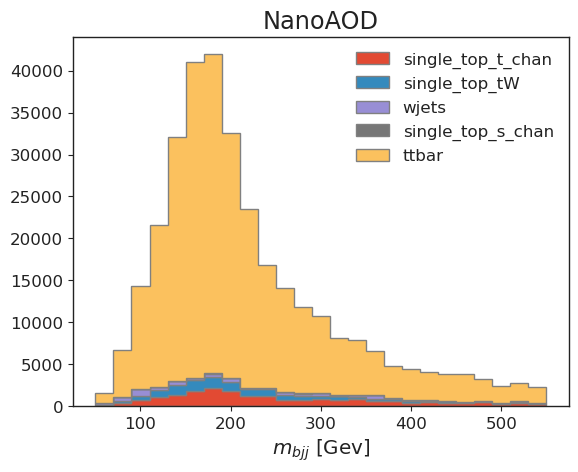

In [36]:
utils.set_style()

topmass_hist.stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title("NanoAOD")
plt.xlabel("$m_{bjj}$ [Gev]");
plt.show()

In [38]:
# define ht histogram

bin_low = 50
bin_high = 550
num_bins = 25
name = "ht"
label = "ht"

ht_hist = (hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
                .StrCat([], name="process", label="Process", growth=True)
                .Weight()
               )

In [39]:
# fill histogram
ht_hist.fill(ht_tt, process = "ttbar", weight = weights_tt)
ht_hist.fill(ht_sc, process = "single_top_s_chan", weight = weights_sc)
ht_hist.fill(ht_wj, process = "wjets", weight = weights_wj)
ht_hist.fill(ht_tw, process = "single_top_tW", weight = weights_tw)
ht_hist.fill(ht_tc, process = "single_top_t_chan", weight = weights_tc)

Hist(
  Regular(25, 50, 550, name='ht', label='ht'),
  StrCategory(['ttbar', 'single_top_s_chan', 'wjets', 'single_top_tW', 'single_top_t_chan'], growth=True, name='process', label='Process'),
  storage=Weight()) # Sum: WeightedSum(value=259198, variance=1.58333e+07) (WeightedSum(value=308618, variance=1.8905e+07) with flow)

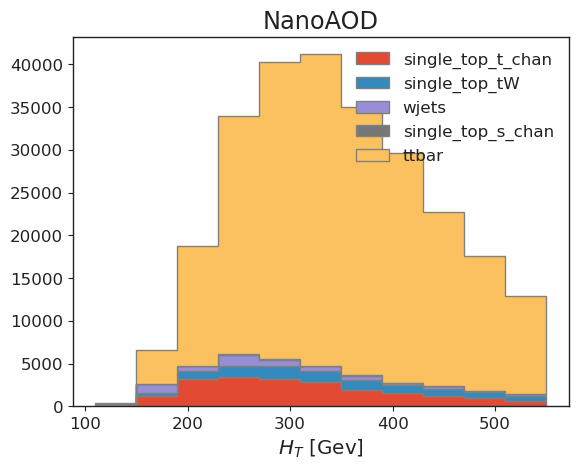

In [42]:
utils.set_style()

ht_hist[120j::hist.rebin(2),:].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title("NanoAOD")
plt.xlabel("$H_T$ [Gev]");
plt.show()